In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt

from scipy.stats import median_abs_deviation as mad
from scipy.optimize import curve_fit

from local_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# WS_file = '/Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/WE__0133___________DER_WS__________________P01.xml'
which_sol = "0241"
path = '/Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/'
WS_file = path + 'WE__%s___________DER_WS__________________P02.xml' % (which_sol)

time, wind = retrieve_time_wind(WS_file, start_time=datetime(1900, 1, 1, 12, 0, 0), 
                                end_time=datetime(1900, 1, 1, 13, 0, 0))
time, wind = retrieve_time_wind(WS_file)
wind *= 100. # Convert to cm/s

Processing label: /Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/WE__0241___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
Processing label: /Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/WE__0241___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE


Text(0, 0.5, '$U\\ \\left( {\\rm m\\ s^{-1}} \\right)$')

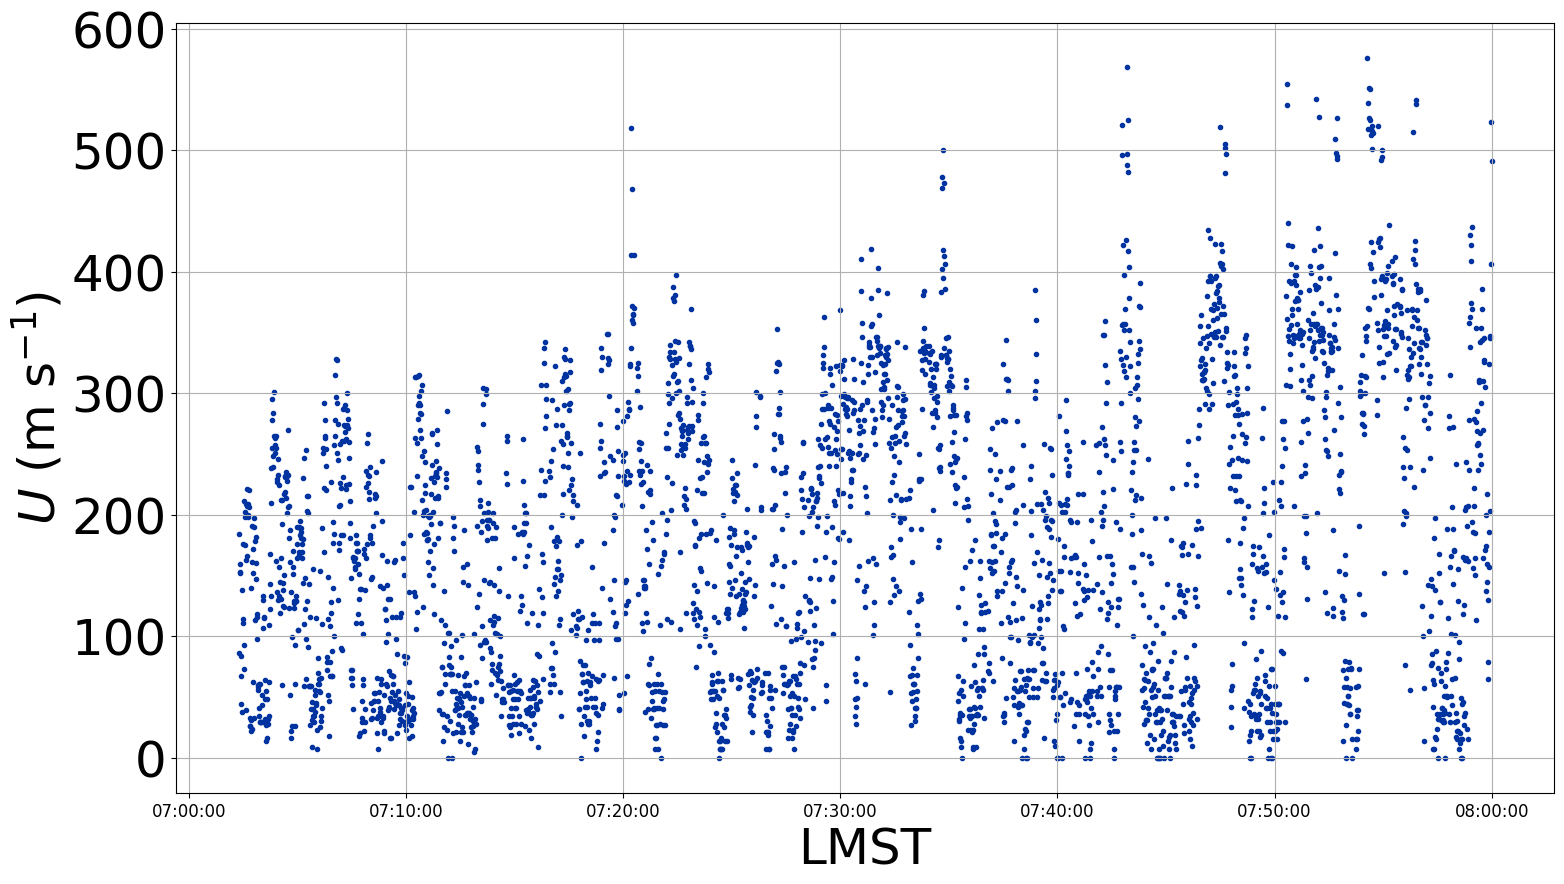

In [48]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

ax.scatter(time, wind, marker='.', color=BoiseState_blue)

xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.grid(True)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=36)
ax.set_xlabel("LMST", fontsize=36)
ax.set_ylabel(r'$U\ \left( {\rm m\ s^{-1}} \right)$', fontsize=36)
# ax.set_xlim([start_time, end_time])

[1.46704906] [[18.11904483]]
13.752475362580833
[5.80096711e-14] [[16.68654121]]
3.0


Text(0, 0.5, '$z\\,\\left( {\\rm cm} \\right)$')

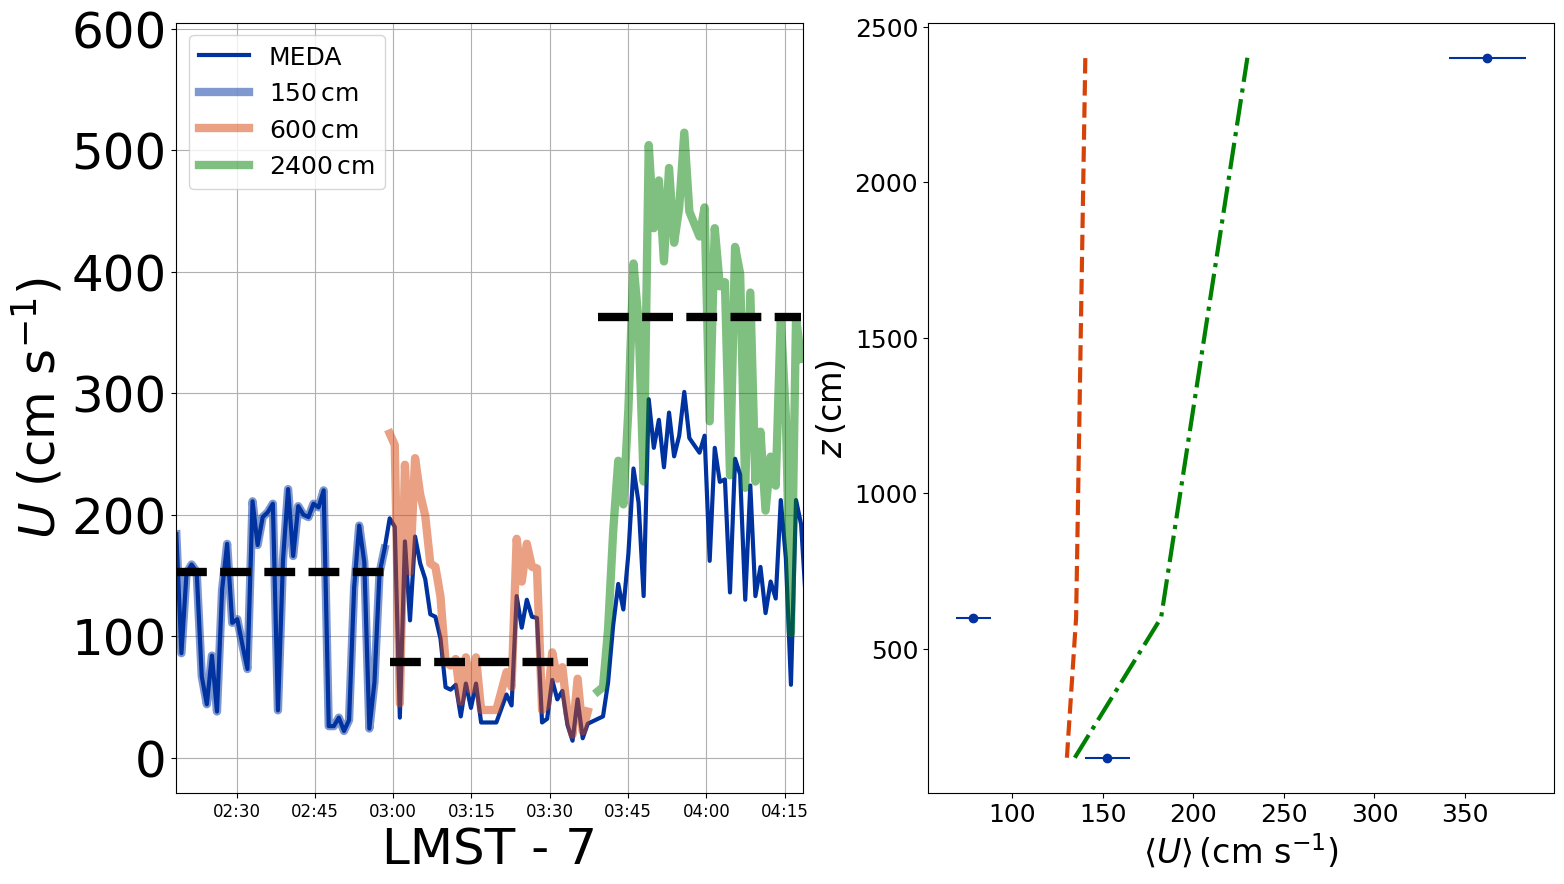

In [49]:
def windspeed_difference(log_z, ustar):
    return ustar/kappa*log_z

def intercept_equation(log_z, log_zstar):
    return log_z - log_zstar

fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

saved_zstar = 3. # cm
t0 = np.min(time)
ind = retrieve_relevant_times(time, t0, len(zs)*sample_time)
saved_ustar = kappa*np.median(wind[ind])/np.log(zs[0]/saved_zstar)

scaled_windspeeds = create_synthetic_wind_profile(wind, zs, saved_zstar, z0=np.min(zs))
t0 = np.min(time)
averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_time, t0, time, scaled_windspeeds, zs)
ax1 = make_plot_of_original_and_scaled_windspeeds(time, wind, zs, sample_time, t0, scaled_windspeeds, 
                                                  averaged_windspeeds, ax1)
ax1.set_xlim([np.min(time), np.min(time) + timedelta(seconds=len(zs)*sampling_duration)])

### Fit synthetic wind profile ###

# inlier_zs, inlier_averaged_windspeeds, inlier_std_windspeeds,\
#     outlier_zs, outlier_averaged_windspeeds, outlier_std_windspeeds,\
#     popt, unc, pcov = fit_wind_profile_and_drop_outliers(zs, averaged_windspeeds, std_windspeeds,
#                                                          drop_outliers=False, num_sigma=5., rescale_unc=True,
#                                                          consider_scaled_uncertainties=False)

# ustar, zstar, sigma_ustar, sigma_zstar = collect_fit_values_and_unc(popt, unc, pcov)
# print(ustar, zstar, sigma_ustar, sigma_zstar)
# ax2 = make_plot_of_wind_data_and_profile(inlier_zs, inlier_averaged_windspeeds, inlier_std_windspeeds,
#                                          outlier_zs, outlier_averaged_windspeeds, outlier_std_windspeeds, 
#                                          popt, unc, pcov, ax2)

# (z, ustar, zstar, kappa=0.4)
delta_u = averaged_windspeeds - averaged_windspeeds[0]
log_z = np.log(zs/zs[0])
ustar, sigma_ustar_sq = curve_fit(windspeed_difference, log_z, delta_u, sigma=std_windspeeds)
sigma_ustar = np.sqrt(sigma_ustar_sq)
print(ustar, sigma_ustar)
print(saved_ustar)

scaled_u = kappa*averaged_windspeeds/ustar
log_z = np.log(zs/np.min(zs))
log_zstar, log_sigma_zstar_sq = curve_fit(intercept_equation, log_z, scaled_u, sigma=kappa*std_windspeeds/ustar)
log_sigma_zstar = np.sqrt(log_sigma_zstar_sq)
zstar = np.min(zs)*np.exp(log_zstar)
print(zstar, log_sigma_zstar)
print(saved_zstar)

ax2.errorbar(averaged_windspeeds, zs, xerr=std_windspeeds, ls='', marker='o', color=BoiseState_blue)
ax2.plot(wind_profile(zs, ustar, zstar), zs, color=BoiseState_orange, lw=3, ls='--')
ax2.plot(wind_profile(zs, saved_ustar, saved_zstar), zs, color='green', lw=3, ls='-.')
ax2.tick_params(labelsize=18)
ax2.set_xlabel(r'$\langle U \rangle\,\left( {\rm cm\ s^{-1} }\right)$', fontsize=24)
ax2.set_ylabel(r'$z\,\left( {\rm cm} \right)$', fontsize=24)

# Check uncertainties
# num_points = 1000
# slope_dist = popt[0] + normal(size=num_points, scale=unc[0])
# intercept_dist = popt[1] + normal(size=num_points, scale=unc[1])

# ustar_dist = calc_ustar_from_slope(slope_dist)
# zstar_dist = calc_zstar_from_slope_and_intercept(np.min(zs), slope_dist, intercept_dist)

# ind = np.argmax(zstar_dist)
# print(slope_dist[ind], intercept_dist[ind], -intercept_dist[ind]/slope_dist[ind])

# ax.hist(ustar_dist, bins='auto')
# ax.axvline(ustar, color=BoiseState_orange)

# ax.hist(zstar_dist, bins='auto')
# ax.axvline(zstar, color=BoiseState_orange)

# ax2.plot(wind_profile(zs, saved_ustar, saved_zstar), zs)

# ax2.text(0.05, 0.725, r'Correct $u_\star = %.0f\, {\rm cm\ s^{-1}}$' % (saved_ustar), 
#          fontsize=28, transform=ax2.transAxes)
# ax2.text(0.05, 0.675, r'Correct $z_\star = %.0f\, {\rm cm}$' % (saved_zstar), 
#          fontsize=28, transform=ax2.transAxes)

# ax1.set_xlim([np.min(time), np.min(time) + timedelta(seconds=len(zs)*sampling_duration)])
# fig.savefig("Synthetic_Mars_Wind_Profile_Sol133.jpg", dpi=300, bbox_inches="tight")